In [2]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
from astropy.io import fits
import os
from joblib import Parallel, delayed
import warnings

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

import sys
sys.path.append(basepath+'note/')
import galaxy

from scipy.ndimage import gaussian_filter

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [3]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

mpl.rcParams.update({'font.size': 8})

In [4]:
GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013

In [17]:
def get_orbit(Rs, Vv, ecc):
    output_dir = basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+ecc+'/output'
    orbit = {}
    orbit['Time'] = []
    orbit['Orbit'] = []
    for idx in tqdm(np.arange(320+1), leave=True, position=0):
        fname = output_dir + '/fof_subhalo_tab_'+str(idx).zfill(3)+'.hdf5'
        
        if not os.path.exists(fname):
            print('got to idx='+str(idx-1)+' for Rs,Vv,ecc='+Rs+','+Vv+','+ecc)
            break
        
        t = h5.File(fname, mode='r')
        orbit['Time'].append(t['Header'].attrs['Time'])
        SubhaloPos = t['Subhalo/SubhaloPos'][:]
        if len(SubhaloPos) > 1:
            orbit['Orbit'].append(SubhaloPos[1] - SubhaloPos[0])
        else:
            orbit['Orbit'].append(np.array([0., 0., 0.]))
        t.close()
    
    for k in orbit.keys():
        orbit[k] = np.array(orbit[k])
    
    orbit['Rsep'] = np.linalg.norm(orbit['Orbit'], axis=1)
        
    return orbit

In [5]:
sim0 = ('142', '116', '04')
sim1 = ('129', '116', '04')
sim2 = ('116', '142', '05')

orbit0 = get_orbit(*sim0)
orbit1 = get_orbit(*sim1)
orbit2 = get_orbit(*sim2)

100%|██████████| 321/321 [00:16<00:00, 19.32it/s]


(0.0, 150.0)

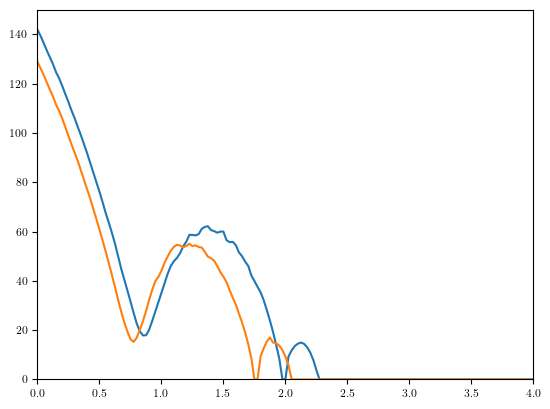

In [6]:
plt.plot(orbit0['Time'], orbit0['Rsep'])
plt.plot(orbit1['Time'], orbit1['Rsep'])
plt.xlim(0, 4)
plt.ylim(0, 150)

In [7]:
print(orbit0['Time'][orbit0['Rsep'] == 0][:10])
print(orbit1['Time'][orbit1['Rsep'] == 0][:10])

[1.9765625  2.         2.27539062 2.30078125 2.32617188 2.3515625
 2.375      2.40039062 2.42578125 2.45117188]
[1.75       1.77539062 2.05078125 2.07617188 2.1015625  2.125
 2.15039062 2.17578125 2.20117188 2.2265625 ]


In [8]:
mergesnap0 = np.where(np.logical_and(orbit0['Time'] > 1.8, orbit0['Rsep'] == 0))[0][0]
mergesnap1 = np.where(np.logical_and(orbit1['Time'] > 1.8, orbit1['Rsep'] == 0))[0][0]

print(mergesnap0)
print(mergesnap1)

79
82


In [9]:
print(np.arange(-20, 40+1, 5))

[-20 -15 -10  -5   0   5  10  15  20  25  30  35  40]


In [10]:
snap_list = np.array([-70, -40, -10, -5, 0, 2, 4, 6, 8, 10, 20, 40, 60])
print(len(snap_list))

13


In [109]:
gals_sim0 = {}
gals_sim1 = {}
for i in tqdm(snap_list):
    snap0 = mergesnap0 + i
    snap1 = mergesnap1 + i
    
    key = 'lvl4-Rs'+sim0[0]+'-Vv'+sim0[1]+'-e'+sim0[2]
    gals_sim0[snap0] = galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output',
                                              snap0, orient=True)

    key = 'lvl4-Rs'+sim1[0]+'-Vv'+sim1[1]+'-e'+sim1[2]
    gals_sim1[snap1] = galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output',
                                              snap1, orient=True)

100%|██████████| 13/13 [00:49<00:00,  3.83s/it]


In [12]:
def get_logFeH_logMgFe_in_SN(gal, rmin=2, rmax=5):
    sn = gal.sn
    FeH = sn.part0.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = sn.part0.GFM_Metals[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH
    
    ### get in_SN ###
    r = np.linalg.norm(sn.part0.rotpos, axis=1)
    in_SN = np.logical_and(r > rmin, r < rmax)

    return logFeH, logMgFe, in_SN

def plot_panel(gal, fig, ax):
    logFeH, logMgFe, in_SN = get_logFeH_logMgFe_in_SN(gal, rmin=6, rmax=10)
    
    key_Fe = np.logical_and(logFeH < -0.2, logFeH > -0.3)
    key = np.logical_and(key_Fe, in_SN)
    
    bins = np.linspace(0.2, 0.5, 100)
    dx = (bins[-1] - bins[0]) / (len(bins)-1)
    
    # print(gal.sn.Time.value, np.sum(key), np.sum(in_SN))
    
    mass = gal.sn.part0.mass.value
    ax.hist(logMgFe[key], bins=bins, weights=mass[key]/dx,
            color='k', histtype='step')
    # ax.hist(logFeH[in_SN], bins=np.linspace(-2, 0.5, 100))
    
    key = np.logical_and(key, gal.sn.part0.sfr > 0)
    ax.hist(logMgFe[key], bins=bins, weights=mass[key]/dx,
            color='k', ls='dotted', histtype='step')
    
    ax.set(xlim=(bins[0], bins[-1]), ylim=(0, 0.5), aspect='auto')
    ax.axvline(0.335, c='k')
    ax.text(0.4, 0.4, 't='+str(round(gal.sn.Time.value, 3)))
    

-70 0.2265625
-40 0.9765625
-10 1.7265625
-5 1.8515625
0 1.9765625
2 2.025390625
4 2.076171875
6 2.125
8 2.17578125
10 2.2265625
20 2.4765625
40 2.9765625
60 3.4765625


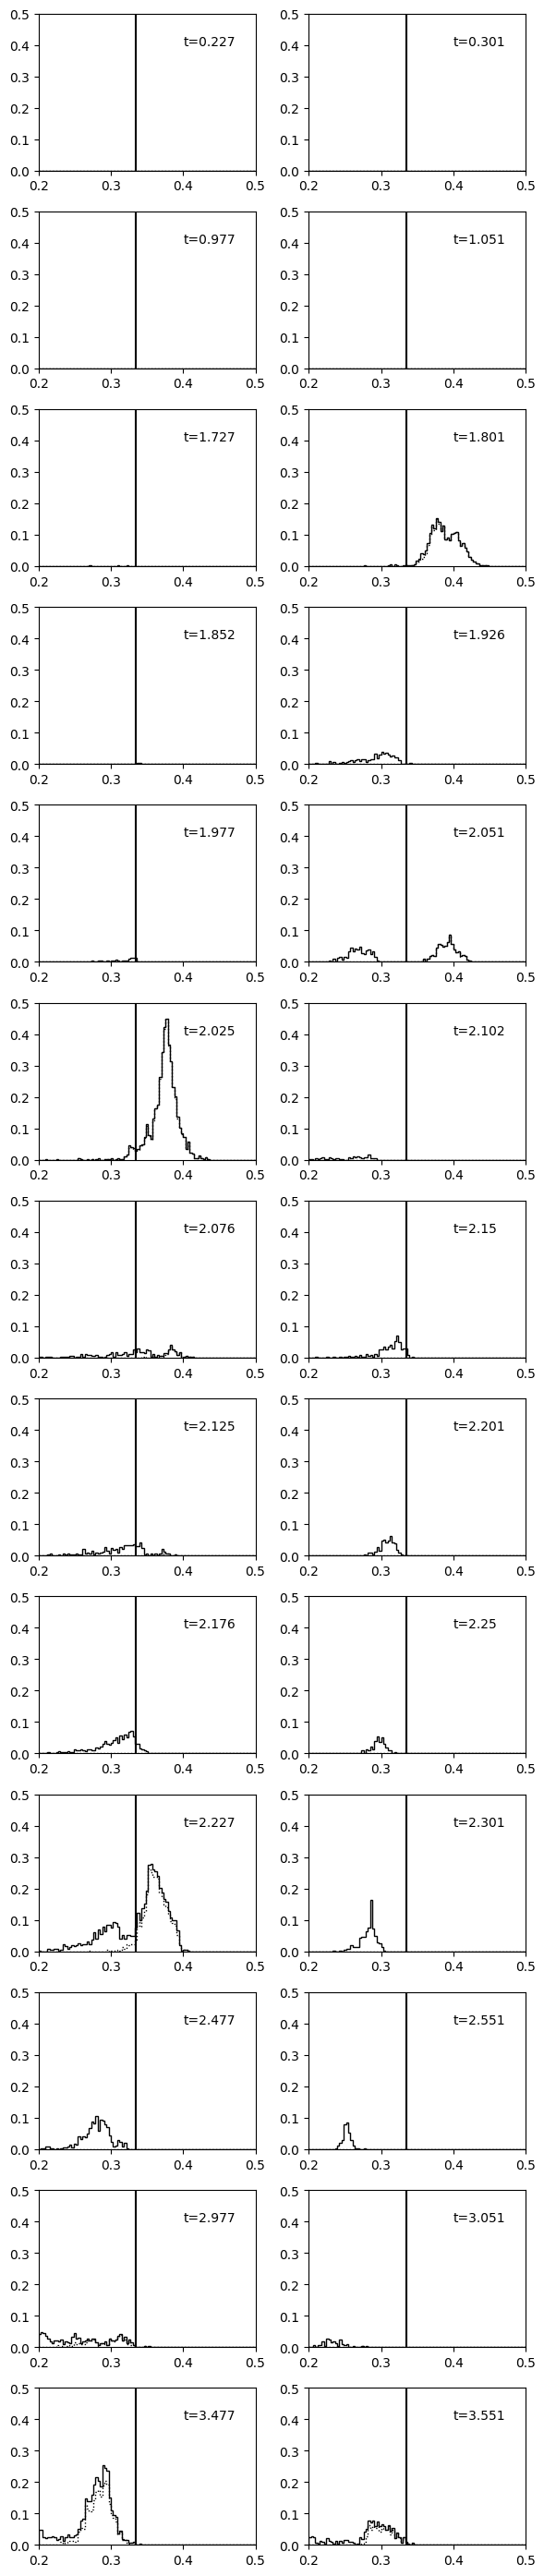

In [111]:
plt.close()
fig, axs = plt.subplots(13, 2, figsize=(6, 28))

for i,(snap0,snap1) in enumerate(zip(gals_sim0.keys(), gals_sim1.keys())):
    gal0, gal1 = gals_sim0[snap0], gals_sim1[snap1]
    
    plot_panel(gal0, fig, axs[i][0])
    plot_panel(gal1, fig, axs[i][1])
    
    print(snap0-mergesnap0, gal0.sn.Time.value)

fig.tight_layout()

In [ ]:
### key = 'lvl4-Rs'+sim0[0]+'-Vv'+sim0[1]+'-e'+sim0[2]
gal320 = galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output',
                                              320, orient=True)
key = 'lvl4-Rs'+sim0[0]+'-Vv'+sim0[1]+'-e'+sim0[2]
gal120 = galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output',
                                              120, orient=True)

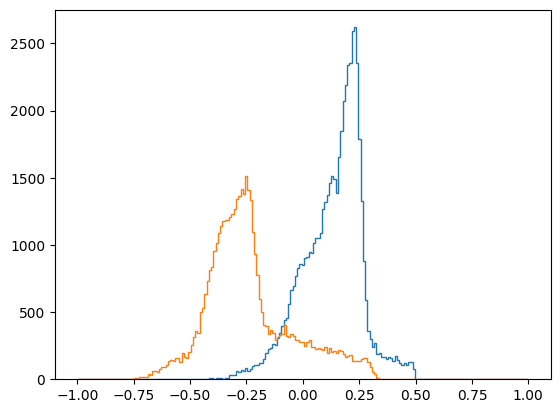

In [45]:
logFeH = np.log10(gal320.sn.part0.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON)
plt.hist(logFeH[gal320.sn.part0.sfr > 0], bins=np.linspace(-1, 1, 200), histtype='step');

logFeH = np.log10(gal120.sn.part0.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON)
plt.hist(logFeH[gal120.sn.part0.sfr > 0], bins=np.linspace(-1, 1, 200), histtype='step');

In [150]:
def plot_gas_phase(gal, fig, ax0, ax1, ax2):

    logFeH_lim=[-1.1, 0.6]
    logMgFe_lim=[0.1, 0.65]
    
    sn = gal.sn

    ### get logFeH and logMgFe ###
    logFeH, logMgFe, in_SN = get_logFeH_logMgFe_in_SN(gal, rmin=6, rmax=10)
    
    N_FeH = 200
    N_MgFe = 200
    FeH_bins  = np.linspace(logFeH_lim[0],  logFeH_lim[1],  N_FeH+1)
    MgFe_bins = np.linspace(logMgFe_lim[0], logMgFe_lim[1], N_MgFe+1)
    dFeH  = (logFeH_lim[1]  - logFeH_lim[0] )/N_FeH
    dMgFe = (logMgFe_lim[1] - logMgFe_lim[0])/N_MgFe

    vmax = 5
    
    key = in_SN
    # print(np.sum(key))
    mass = sn.part0.mass.value
    H, _, _, _ = binned_statistic_2d(logFeH[key], logMgFe[key], 
                                     mass[key]/dFeH/dMgFe,
                                     statistic='sum', bins=[FeH_bins, MgFe_bins])
    
    im = ax0.imshow(H.T, origin='lower', extent=[logFeH_lim[0],  logFeH_lim[1],
                                                logMgFe_lim[0], logMgFe_lim[1]],
                    cmap='Greys', vmin=0, vmax=vmax)
    
    # print(im.get_clim())
    
    key = np.logical_and(in_SN, sn.part0.sfr > 0)
    # print(np.sum(key))
    if np.sum(key) == 0:
        Hsf = np.zeros_like(H)
    else:
        Hsf, _, _, _ = binned_statistic_2d(logFeH[key], logMgFe[key], 
                                     mass[key]/dFeH/dMgFe,
                                     statistic='sum', bins=[FeH_bins, MgFe_bins])
    
    im = ax1.imshow(Hsf.T, origin='lower', extent=[logFeH_lim[0],  logFeH_lim[1],
                                                logMgFe_lim[0], logMgFe_lim[1]],
                    cmap='Greys', vmin=0, vmax=vmax)

    Hfrac = np.divide(Hsf, H, where=H>0)
    Hfrac[H <= 1] = 0
    
    im = ax2.imshow(Hfrac.T, origin='lower', extent=[logFeH_lim[0],  logFeH_lim[1],
                                                logMgFe_lim[0], logMgFe_lim[1]],
                    cmap='Greys', vmin=0, vmax=1)
    
    # print(im.get_clim())
    
    
    ax0.set(xlim=logFeH_lim, ylim=logMgFe_lim)
    # ax0.set(xlabel=r'$[\textrm{Fe}/\textrm{H}]$')
    ax0.set(aspect='auto')
    ax1.set(aspect='auto')
    ax2.set(aspect='auto')
    
    m = -0.15/1.5
    b = 0.31
    xlist = np.linspace(-3, 3, 1000)
    ylist = m*xlist + b
    ax0.plot(xlist, ylist, c='k', ls='dashed', lw=0.5)
    ax1.plot(xlist, ylist, c='k', ls='dashed', lw=0.5)
    ax2.plot(xlist, ylist, c='k', ls='dashed', lw=0.5)
    ax0.text(0, 0.45, 't='+str(round(gal.sn.Time.value, 3))+'Gyr')
    
    return H

# axs[0].set(ylabel=r'$[\textrm{Mg}/\textrm{Fe}]$')

# axs[0].set_title(r'$\textrm{all stars}$')
# axs[1].set_title(r'$\textrm{before merger}$')
# axs[2].set_title(r'$\textrm{during merger}$')
# axs[3].set_title(r'$\textrm{after merger}$')

# key = np.logical_and(keybool, tform < tmerge[0])
# H, _, _, _ = binned_statistic_2d(logFeH[key], logMgFe[key], 
#                                  np.ones(np.sum(key))/dFeH/dMgFe,
#                                  statistic='sum', bins=[FeH_bins, MgFe_bins])


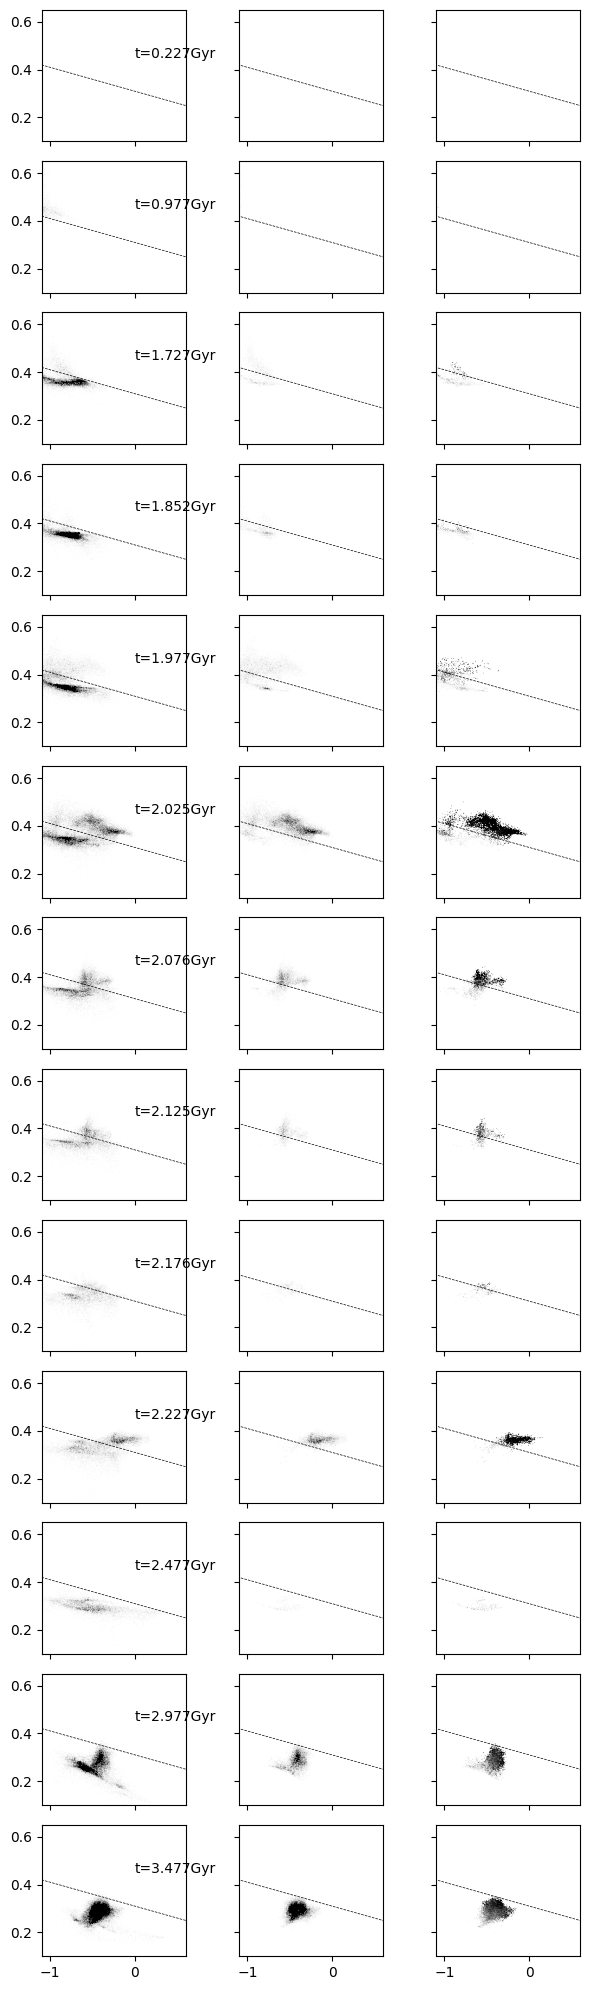

In [151]:
fig, axs = plt.subplots(13, 3, figsize=(6, 20), sharex=True, sharey=True)

for i,(snap0,snap1) in enumerate(zip(gals_sim0.keys(), gals_sim1.keys())):
    gal0, gal1 = gals_sim0[snap0], gals_sim1[snap1]
    
    H = plot_gas_phase(gal0, fig, axs[i][0], axs[i][1], axs[i][2])
    # plot_panel(gal1, fig, axs[i][1])
fig.tight_layout()

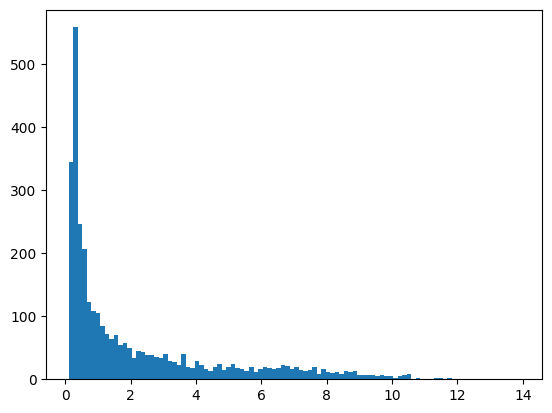

In [147]:
plt.hist(H.ravel()[H.ravel() > 0], bins=100);

# gas mass and sfr vs time

In [13]:
idx_list = np.arange(0, 200+1, 1)

In [14]:
def get_mass_in_seq(idx, sim, yoff_list, rmin=2, rmax=5):
    out = {}
    Rs = sim[0]
    Vv = sim[1]
    ecc = sim[2]
    
    m = -0.15/1.5
    b = 0.31
    
    key = 'lvl4-Rs'+sim0[0]+'-Vv'+sim0[1]+'-e'+sim0[2]
    output_dir = basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output'
    
    sub = h5.File(output_dir + '/fof_subhalo_tab_'+str(idx).zfill(3)+'.hdf5', mode='r')
    sub0pos = sub['Subhalo/SubhaloPos'][0]
    sub.close()

    snap = h5.File(output_dir + '/snapshot_'+str(idx).zfill(3)+'.hdf5', mode='r')
    
    pos0 = snap['PartType0/Coordinates'][:]
    r0 = np.linalg.norm(pos0 - sub0pos, axis=1)
    in_SN = np.logical_and(r0 > rmin, r0 < rmax)
    
    mass0 = snap['PartType0/Masses'][:]
    sfr0 = snap['PartType0/StarFormationRate'][:]
    
    metals0 = snap['PartType0/GFM_Metals'][:]
    FeH = metals0[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = metals0[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH
    
    dy = 0.01
    
    out['Mgas'] = np.zeros_like(yoff_list)
    out['Msf'] = np.zeros_like(yoff_list)
    out['SFR'] = np.zeros_like(yoff_list)
    
    y0 = m*logFeH + b
    y = logMgFe
    for i,yoff in enumerate(yoff_list):
        key = np.logical_and((y-y0) > yoff - dy, (y-y0) < yoff + dy)
        key = np.logical_and(key, in_SN)
        
        keyFe = np.logical_and(logFeH > -0.3, logFeH < -0.2)
        key = np.logical_and(key, keyFe)
        
        keysf = np.logical_and(key, sfr0 > 0)
        
        out['Mgas'][i] = np.sum(mass0[key])
        out['Msf'][i] = np.sum(mass0[keysf])
        out['SFR'][i] = np.sum(sfr0[key])
    
    out['Time'] = snap['Header'].attrs['Time']
    
    snap.close()
    
    return out
        

In [239]:
# yoff_list = np.array([-0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2])
yoff_list = np.array([-0.04, 0, 0.04])
outs = Parallel(n_jobs=16) (delayed(get_mass_in_seq)(idx, sim0, yoff_list) 
                            for idx in tqdm(np.arange(320+1)))

dat = {}
for k in outs[0].keys():
    dat[k] = []

for out in outs:
    for k in dat.keys():
        dat[k].append(out[k])
    
for k in dat.keys():
    dat[k] = np.array(dat[k])

dat['y_offsets'] = yoff_list

100%|██████████| 321/321 [00:02<00:00, 121.44it/s]


[-0.04  0.    0.04]


/tmp/ipykernel_2836256/1932061856.py:13: RuntimeWarning: invalid value encountered in divide
  axs[1].plot(dat['Time'], dat['Msf'][:,2]/dat['Mgas'][:,2])
/tmp/ipykernel_2836256/1932061856.py:14: RuntimeWarning: invalid value encountered in divide
  axs[1].plot(dat['Time'], dat['Msf'][:,1]/dat['Mgas'][:,1])
/tmp/ipykernel_2836256/1932061856.py:15: RuntimeWarning: invalid value encountered in divide
  axs[1].plot(dat['Time'], dat['Msf'][:,0]/dat['Mgas'][:,0])


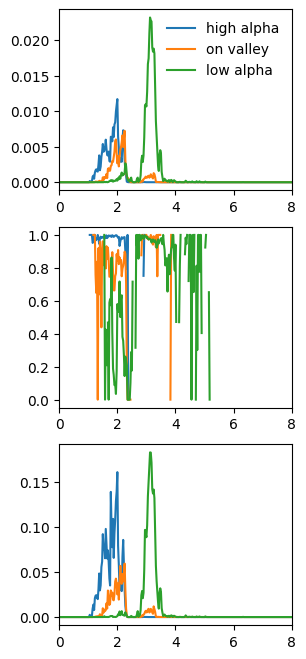

In [240]:
print(dat['y_offsets'])

fig, axs = plt.subplots(3, 1, figsize=(3, 8))

axs[0].plot(dat['Time'], dat['Mgas'][:,2], label='high alpha')
axs[0].plot(dat['Time'], dat['Mgas'][:,1], label='on valley')
axs[0].plot(dat['Time'], dat['Mgas'][:,0], label='low alpha')

# axs[1].plot(dat['Time'], 0.1*dat['Mgas'][:,2]/dat['SFR'][:,2])
# axs[1].plot(dat['Time'], 0.1*dat['Mgas'][:,1]/dat['SFR'][:,1])
# axs[1].plot(dat['Time'], 0.1*dat['Mgas'][:,0]/dat['SFR'][:,0])

axs[1].plot(dat['Time'], dat['Msf'][:,2]/dat['Mgas'][:,2])
axs[1].plot(dat['Time'], dat['Msf'][:,1]/dat['Mgas'][:,1])
axs[1].plot(dat['Time'], dat['Msf'][:,0]/dat['Mgas'][:,0])

axs[2].plot(dat['Time'], dat['SFR'][:,2])
axs[2].plot(dat['Time'], dat['SFR'][:,1])
axs[2].plot(dat['Time'], dat['SFR'][:,0])

axs[0].set(xlim=(0, 8))
# axs[1].set(xlim=(0, 8), yscale='log')
axs[1].set(xlim=(0, 8))
axs[2].set(xlim=(0, 8))


axs[0].legend(frameon=False)

In [45]:
h5.Dataset.id.set_cache_size(32 * 1024 * 1024)  # Increase to 32 MB

AttributeError: 'property' object has no attribute 'set_cache_size'

In [50]:
%%time
sim = ('142', '142', '04')
idx = 80
key = 'lvl4-Rs'+sim[0]+'-Vv'+sim[1]+'-e'+sim[2]
output_dir = basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output'

sub = h5.File(output_dir + '/fof_subhalo_tab_'+str(idx).zfill(3)+'.hdf5', mode='r')
sub0pos = sub['Subhalo/SubhaloPos'][0]
sub.close()

snap = h5.File(output_dir + '/snapshot_'+str(idx).zfill(3)+'.hdf5', mode='r')

NumPart_Total = snap['Header'].attrs['NumPart_Total']
Time = snap['Header'].attrs['Time']

pos4 = snap['PartType4/Coordinates'][:]
age4 = snap['PartType4/GFM_StellarFormationTime'][:]
mass4 = snap['PartType4/Masses'][:]
metals4 = snap['PartType4/GFM_Metals'][:]

mass0 = snap['PartType0/Masses'][:]
sfr0 = snap['PartType0/StarFormationRate'][:]
    
pos0 = snap['PartType0/Coordinates'][:]
    
metals0 = snap['PartType0/GFM_Metals'][:]
sclr = snap['PartType0/PassiveScalars'][:]

snap.close()

CPU times: user 11 ms, sys: 32.9 ms, total: 44 ms
Wall time: 44.4 ms


In [16]:
def get_summary(idx, sim, rmin=2, rmax=5, dsnap=0.025, rgal=15):
    out = {}
    Rs = sim[0]
    Vv = sim[1]
    ecc = sim[2]
    
    key = 'lvl4-Rs'+sim[0]+'-Vv'+sim[1]+'-e'+sim[2]
    output_dir = basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output'
    
    sub = h5.File(output_dir + '/fof_subhalo_tab_'+str(idx).zfill(3)+'.hdf5', mode='r')
    sub0pos = sub['Subhalo/SubhaloPos'][0]
    sub.close()

    snap = h5.File(output_dir + '/snapshot_'+str(idx).zfill(3)+'.hdf5', mode='r')
    NumPart_Total = snap['Header'].attrs['NumPart_Total']
    Time = snap['Header'].attrs['Time']
    out['Time'] = Time
    
    mass0 = snap['PartType0/Masses'][:]
    sclr0 = snap['PartType0/PassiveScalars'][:]
    sfr0 = snap['PartType0/StarFormationRate'][:]
    pos0 = snap['PartType0/Coordinates'][:]
    metals0 = snap['PartType0/GFM_Metals'][:]
    
    out['BH_Mdot'] = snap['PartType5/BH_Mdot'][0]
    out['BH_CumEgyInjection_QM'] = snap['PartType5/BH_CumEgyInjection_QM'][0]
    out['BH_CumEgyInjection_RM'] = snap['PartType5/BH_CumEgyInjection_RM'][0]
    out['BH_MdotEddington'] = snap['PartType5/BH_MdotEddington'][0]
    out['BH_Mass'] = snap['PartType5/Masses'][0]
    
    if NumPart_Total[4] > 0:
        pos4 = snap['PartType4/Coordinates'][:]
        age4 = snap['PartType4/GFM_StellarFormationTime'][:]
        mass4 = snap['PartType4/Masses'][:]
        metals4 = snap['PartType4/GFM_Metals'][:]
        
        r4 = np.linalg.norm(pos4 - sub0pos, axis=1)
        is_star_in_SN = np.logical_and(r4 > rmin, r4 < rmax)
        is_star_in_SN = np.logical_and(is_star_in_SN, age4 > 0)
        
        is_star_in_gal = np.logical_and(age4 > 0, r4 < rgal)
        
        is_in_agebin = np.logical_and(age4 <= Time, age4 > Time - dsnap)
        
        
        FeH4 = metals4[:,8] / GFM_SOLAR_ABUNDANCE_IRON
        MgH4 = metals4[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
        
        logFeH4 = np.log10(FeH4)
        logMgH4 = np.log10(MgH4)
        logMgFe4 = logMgH4 - logFeH4
        
        out['Mstar'] = np.sum(mass4[is_star_in_SN])
        out['globalMstar'] = np.sum(mass4[is_star_in_gal])
        
        key = np.logical_and(is_star_in_SN, is_in_agebin)
        out['dMstar'] = np.sum(mass4[key])
    else:
        out['Mstar'] = 0.0
        out['dMstar'] = 0.0
        out['globalMstar'] = 0.0
    
    r0 = np.linalg.norm(pos0 - sub0pos, axis=1)
    in_SN = np.logical_and(r0 > rmin, r0 < rmax)
    in_gal = r0 < rgal
    
    FeH = metals0[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = metals0[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH
    
    
    
    out['Mgas'] = np.sum(mass0[in_SN])
    out['SFR'] = np.sum(sfr0[in_SN])
    
    out['globalSFR'] = np.sum(sfr0[in_gal])
    out['globalMgas'] = np.sum(mass0[in_gal])
    
    dlogFeH = 0.1
    logFeH0_list = np.arange(-1, 0.5+0.1, 0.1)
    Mgas_inFeHbin = np.zeros_like(logFeH0_list)
    SFR_inFeHbin = np.zeros_like(logFeH0_list)
    medalpha_inFeHbin = np.zeros_like(logFeH0_list)
    
    MFe_inFeHbin_cen = np.zeros_like(logFeH0_list)
    MMg_inFeHbin_cen = np.zeros_like(logFeH0_list)
    MFe_inFeHbin_sat = np.zeros_like(logFeH0_list)
    MMg_inFeHbin_sat = np.zeros_like(logFeH0_list)
    
    for i,logFeH0 in enumerate(logFeH0_list):
        key = np.logical_and(logFeH - logFeH0 < dlogFeH/2., logFeH - logFeH0 > -dlogFeH/2)
        key = np.logical_and(key, in_SN)
        
        Mgas_inFeHbin[i] = np.sum(mass0[key])
        SFR_inFeHbin[i] = np.sum(sfr0[key])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            medalpha_inFeHbin[i] = np.median(logMgFe[key])
            
        MFe_inFeHbin_cen[i] = np.sum(sclr0[key,0] * mass0[key] * metals0[key,8])
        MMg_inFeHbin_cen[i] = np.sum(sclr0[key,0] * mass0[key] * metals0[key,6])
        MFe_inFeHbin_sat[i] = np.sum(sclr0[key,2] * mass0[key] * metals0[key,8])
        MMg_inFeHbin_sat[i] = np.sum(sclr0[key,2] * mass0[key] * metals0[key,6])
    
    out['Mgas_inFeHbin'] = Mgas_inFeHbin
    out['SFR_inFeHbin'] = SFR_inFeHbin
    out['medalpha_inFeHbin'] = medalpha_inFeHbin
    
    out['MFe_inFeHbin_cen'] = MFe_inFeHbin_cen
    out['MMg_inFeHbin_cen'] = MMg_inFeHbin_cen
    out['MFe_inFeHbin_sat'] = MFe_inFeHbin_sat
    out['MMg_inFeHbin_sat'] = MMg_inFeHbin_sat
    
    out['Mgas_cen'] = np.sum(sclr0[in_SN,0]*mass0[in_SN])
    out['Mgas_sat'] = np.sum(sclr0[in_SN,2]*mass0[in_SN])
    
    out['dlogFeH'] = dlogFeH
    
    
    snap.close()
    
    return out

In [53]:
%%prun
get_summary(80, ('142', '142', '04'))

         2277 function calls (2267 primitive calls) in 0.402 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.305    0.305    0.400    0.400 3291147827.py:1(get_summary)
       10    0.041    0.004    0.041    0.004 {method 'read' of 'h5py._selector.Reader' objects}
      133    0.027    0.000    0.027    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        2    0.021    0.011    0.047    0.024 linalg.py:2383(norm)
        1    0.002    0.002    0.402    0.402 <string>:1(<module>)
        2    0.001    0.000    0.001    0.000 files.py:215(make_fid)
        2    0.001    0.000    0.001    0.000 files.py:571(close)
       12    0.001    0.000    0.001    0.000 group.py:348(__getitem__)
       16    0.000    0.000    0.000    0.000 {method 'partition' of 'numpy.ndarray' objects}
       10    0.000    0.000    0.000    0.000 dataset.py:522(_fast_reader)
       16    0.000    0.000    0.000    0.000 _methods.py

In [12]:
logFeH0_list = np.arange(-1, 0.5+0.1, 0.1)
print(logFeH0_list[10])

-2.220446049250313e-16


In [9]:
def get_dat_summary(sim, rmin=2, rmax=5, use_tqdm=True):

    if use_tqdm:
        itr = tqdm(np.arange(320+1), position=0, leave=True)
    else:
        itr = np.arange(320+1)
    
    outs = Parallel(n_jobs=16) (delayed(get_summary)(idx, sim, rmin=rmin, rmax=rmax) 
                                for idx in itr)

    dat = {}
    for k in outs[0].keys():
        dat[k] = []

    for out in outs:
        for k in dat.keys():
            dat[k].append(out[k])
    
    for k in dat.keys():
        dat[k] = np.array(dat[k])

    return dat

In [14]:
summary0 = get_dat_summary(sim0, rmin=0, rmax=12)
summary1 = get_dat_summary(sim1, rmin=0, rmax=12)
summary2 = get_dat_summary(sim2, rmin=0, rmax=12)
# summary2 = get_dat_summary(sim2)

100%|██████████| 321/321 [00:14<00:00, 22.56it/s]


[(0.0, 8.0), (0.0, 1.0)]

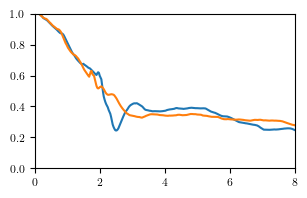

In [15]:
fgas0 = summary0['globalMgas'] / (summary0['globalMgas'] + summary0['globalMstar'])
fgas1 = summary1['globalMgas'] / (summary1['globalMgas'] + summary1['globalMstar'])

fig, ax = plt.subplots(1, 1, figsize=(columnwidth, 0.6*columnwidth))
ax.plot(summary0['Time'], fgas0)
ax.plot(summary1['Time'], fgas1)
ax.set(xlim=(0, 8), ylim=(0, 1))

[(0.0, 8.0), (0.0, 0.003398498311617004)]

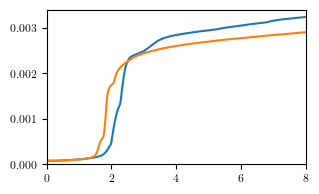

In [16]:

fig, ax = plt.subplots(1, 1, figsize=(columnwidth, 0.6*columnwidth))
ax.plot(summary0['Time'], summary0['BH_Mass'])
ax.plot(summary1['Time'], summary1['BH_Mass'])
ax.set(xlim=(0, 8), ylim=(0, None))

['$\\textrm{SFR}$', '$[\\alpha/\\textrm{Fe}]$']


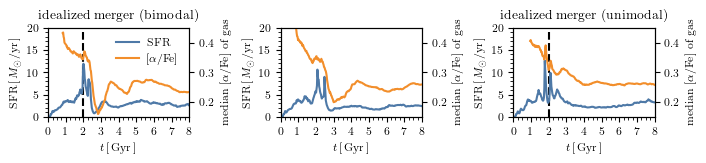

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(textwidth, 0.5*columnwidth))

i_Fe = 10

for i,(ax,summary) in enumerate(zip(axs, [summary0, summary2, summary1])):
    # ax.plot(summary['Time'], 100*summary['Mgas_inFeHbin'][:,8], c=tb_c[0], label=r'$M_{\textrm{gas}}$')
    l0 = ax.plot(summary['Time'], summary['globalSFR'], c=tb_c[0], label=r'$\textrm{SFR}$')
    ax2 = ax.twinx()
    l1 = ax2.plot(summary['Time'], summary['medalpha_inFeHbin'][:,i_Fe], 
             c=tb_c[1], label=r'$[\alpha/\textrm{Fe}]$')
    
    if i==0:
        lns = l0 + l1
        labs = [l.get_label() for l in lns]
        print(labs)
        ax.legend(lns, labs, frameon=False)
        
        # ax.fill_between([2.5, 2.75], [0, 0], [20, 20], color='k', alpha=0.3, lw=0)
    
    ax2.set(ylim=(0.15, 0.45))
    ax.set(xlim=(1, 8), ylim=(0, 20))
    
    ax.set(xlabel=r'$t\,[\,\textrm{Gyr}\,]$', ylabel=r'$\textrm{SFR}\,[\,M_{\odot}/\textrm{yr}\,]$')
    ax2.set(ylabel=r'$\textrm{median }[\alpha/\textrm{Fe}]\textrm{ of gas}$')
    
    ax.set(xticks=np.arange(0, 8+1, 1))
    ax.set_xticks(np.arange(0, 8+0.25, 0.25), minor=True)
    ax.set_yticks(np.arange(0, 20+1, 1), minor=True)
    # ax.set(xlim=(1, 4))


axs[0].axvline(2, c='k', ls='dashed', zorder=-1)
axs[2].axvline(2, c='k', ls='dashed', zorder=-1)

axs[0].set_title(r'$\textrm{idealized merger (bimodal)}$')
axs[2].set_title(r'$\textrm{idealized merger (unimodal)}$')

fig.tight_layout()
fig.savefig('SFR_alpha.pdf')

In [91]:
bim_rank = {}
for Rs in ['116', '129', '142']:
    bim_rank[Rs] = {}
    for Vv in ['116', '129', '142']:
        bim_rank[Rs][Vv] = {}

bim_rank['129']['129']['04'] = 'a'
bim_rank['129']['116']['04'] = 'b'
bim_rank['116']['116']['04'] = 'c'
bim_rank['142']['116']['05'] = 'd'
bim_rank['142']['129']['06'] = 'e'
bim_rank['116']['129']['04'] = 'f'
bim_rank['116']['116']['05'] = 'g'
bim_rank['116']['142']['04'] = 'h'
bim_rank['142']['142']['05'] = 'i'
bim_rank['129']['142']['05'] = 'j'
bim_rank['142']['129']['04'] = 'k'
bim_rank['142']['142']['06'] = 'l'
bim_rank['116']['129']['05'] = 'm'
bim_rank['129']['129']['05'] = 'n'
bim_rank['129']['116']['05'] = 'o'
bim_rank['116']['116']['06'] = 'p'
bim_rank['116']['129']['06'] = 'q'
bim_rank['142']['129']['05'] = 'r'
bim_rank['142']['116']['04'] = 's'
bim_rank['116']['142']['06'] = 't'
bim_rank['116']['142']['05'] = 'u'
bim_rank['142']['116']['06'] = 'v'
bim_rank['129']['142']['06'] = 'w'
bim_rank['142']['142']['04'] = 'x'
bim_rank['129']['116']['06'] = 'y'
bim_rank['129']['129']['06'] = 'z'
bim_rank['129']['142']['04'] = 'aa'

In [102]:
def make_sfr_alpha(sim, summary=None, use_tqdm=False):
    if summary is None:
        summary = get_dat_summary(sim, rmin=0, rmax=12, use_tqdm=use_tqdm)

    fig, ax = plt.subplots(1, 1, figsize=(columnwidth, 0.7*columnwidth))

    i_Fe = 10

    # ax.plot(summary['Time'], 100*summary['Mgas_inFeHbin'][:,8], c=tb_c[0], label=r'$M_{\textrm{gas}}$')
    l1 = ax.plot(summary['Time'], summary['SFR_inFeHbin'][:,i_Fe]/summary['dlogFeH'], 
                 c=tb_c[4])
    l0 = ax.plot(summary['Time'], summary['globalSFR'], c=tb_c[0], label=r'$\textrm{SFR}$')
    
    
    
    ax2 = ax.twinx()
    l2 = ax2.plot(summary['Time'], summary['medalpha_inFeHbin'][:,i_Fe], 
                  c=tb_c[1], label=r'$[\alpha/\textrm{Fe}]$')
    
    lns = l0 + l2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, frameon=False)
        
    ax2.set(ylim=(0.15, 0.45))
    ax.set(xlim=(1, 8), ylim=(0, 20))
    
    ax.set(xlabel=r'$t\,[\,\textrm{Gyr}\,]$', ylabel=r'$\textrm{SFR}\,[\,M_{\odot}/\textrm{yr}\,]$')
    ax2.set(ylabel=r'$\textrm{median }[\alpha/\textrm{Fe}]\textrm{ of gas}$')
    
    ax.set(xticks=np.arange(0, 8+1, 1))
    ax.set_xticks(np.arange(0, 8+0.25, 0.25), minor=True)
    ax.set_yticks(np.arange(0, 20+1, 1), minor=True)

    brnk = bim_rank[sim[0]][sim[1]][sim[2]]
    ttl = r'$(R_s,\,V_v,\,ecc)=('+str(sim[0])+',\,'+str(sim[1])+',\,'+str(sim[2])+r') '+brnk+'$'
    ax.set_title(ttl)

    fig.tight_layout()
    fname = 'sfr_alpha_all/'+brnk+'_'+str(sim[0])+'_'+str(sim[1])+'_'+str(sim[2])+'.pdf'
    fig.savefig(fname)

100%|██████████| 321/321 [00:22<00:00, 14.34it/s]


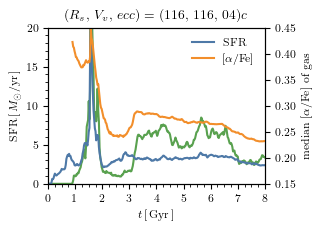

In [103]:
make_sfr_alpha(('116', '116', '04'), use_tqdm=True)

In [104]:
from itertools import product

Rs_values = ['116', '129', '142']
Vv_values = ['116', '129', '142']
ecc_values = ['04', '05', '06']

# Create a single iterator using itertools.product
sims = list(product(Rs_values, Vv_values, ecc_values))

for sim in tqdm(sims, leave=True,  position=0):
    make_sfr_alpha(sim)
    plt.close()

100%|██████████| 27/27 [11:56<00:00, 26.54s/it]


In [80]:
summary0 = get_dat_summary(sim0, rmin=0, rmax=12, use_tqdm=True)

100%|██████████| 321/321 [00:09<00:00, 33.37it/s]


In [57]:
summary0.keys()

dict_keys(['Time', 'Mstar', 'dMstar', 'globalMstar', 'Mgas', 'SFR', 'globalSFR', 'globalMgas', 'Mgas_inFeHbin', 'SFR_inFeHbin', 'medalpha_inFeHbin', 'MFe_inFeHbin_cen', 'MMg_inFeHbin_cen', 'MFe_inFeHbin_sat', 'MMg_inFeHbin_sat', 'dlogFeH'])

/tmp/ipykernel_1050540/1473942560.py:23: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend(lns, labs, frameon=False)


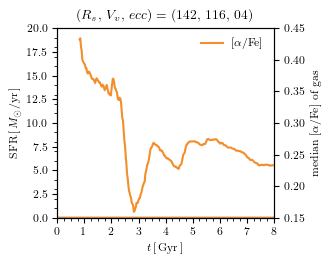

In [62]:
make_sfr_alpha(sim0, summary=summary0, use_tqdm=True)

/tmp/ipykernel_1050540/911701451.py:8: RuntimeWarning: invalid value encountered in divide
  ax2.plot(summary0['Time'], summary0['MFe_inFeHbin_sat'][:,i_Fe]/summary0['MFe_inFeHbin_cen'][:,i_Fe], c='k')


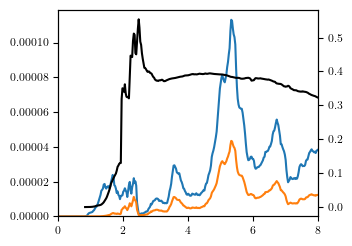

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(columnwidth, 0.8*columnwidth))
i_Fe = 10
l0 = ax.plot(summary0['Time'], summary0['MFe_inFeHbin_cen'][:,i_Fe])
l1 = ax.plot(summary0['Time'], summary0['MFe_inFeHbin_sat'][:,i_Fe])
ax.set(xlim=(0, 8), ylim=(0, None))

ax2 = ax.twinx()
ax2.plot(summary0['Time'], summary0['MFe_inFeHbin_sat'][:,i_Fe]/summary0['MFe_inFeHbin_cen'][:,i_Fe], c='k')

# ax.plot(summary0['Time'], summary0['MMg_inFeHbin_cen'][:,i_Fe], c=l0[0].get_color(), ls='dashed')
# ax.plot(summary0['Time'], summary0['MMg_inFeHbin_sat'][:,i_Fe], c=l1[0].get_color(), ls='dashed')

# ax.plot(summary0['Time'], summary0['MMg_inFeHbin_cen'][:,i_Fe]/summary0['MFe_inFeHbin_cen'][:,i_Fe])
# ax.plot(summary0['Time'], summary0['MMg_inFeHbin_sat'][:,i_Fe]/summary0['MFe_inFeHbin_sat'][:,i_Fe])

# ax.plot(summary0['Time'], summary0['MFe_inFeHbin_sat'][:,i_Fe]/summary0['MFe_inFeHbin_cen'][:,i_Fe])

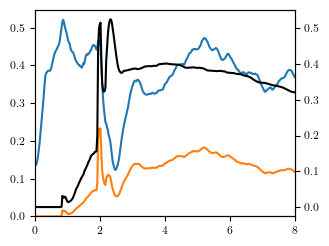

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(columnwidth, 0.8*columnwidth))
i_Fe = 10
l0 = ax.plot(summary0['Time'], summary0['Mgas_cen'])
l1 = ax.plot(summary0['Time'], summary0['Mgas_sat'])
ax.set(xlim=(0, 8), ylim=(0, None))

ax2 = ax.twinx()
ax2.plot(summary0['Time'], summary0['Mgas_sat']/summary0['Mgas_cen'], c='k')

# ax.plot(summary0['Time'], summary0['MMg_inFeHbin_cen'][:,i_Fe], c=l0[0].get_color(), ls='dashed')
# ax.plot(summary0['Time'], summary0['MMg_inFeHbin_sat'][:,i_Fe], c=l1[0].get_color(), ls='dashed')

# ax.plot(summary0['Time'], summary0['MMg_inFeHbin_cen'][:,i_Fe]/summary0['MFe_inFeHbin_cen'][:,i_Fe])
# ax.plot(summary0['Time'], summary0['MMg_inFeHbin_sat'][:,i_Fe]/summary0['MFe_inFeHbin_sat'][:,i_Fe])

# ax.plot(summary0['Time'], summary0['MFe_inFeHbin_sat'][:,i_Fe]/summary0['MFe_inFeHbin_cen'][:,i_Fe])

In [89]:
def make_Mgas_scalar(sim, summary=None, use_tqdm=False):
    if summary is None:
        summary = get_dat_summary(sim, rmin=0, rmax=12, use_tqdm=use_tqdm)

    fig, ax = plt.subplots(1, 1, figsize=(columnwidth, 0.8*columnwidth))
    
    l0 = ax.plot(summary['Time'], summary['Mgas_cen'], label='central')
    l1 = ax.plot(summary['Time'], summary['Mgas_sat'], label='satellite')
    l2 = ax.plot(summary['Time'], summary['Mgas_sat']/summary['Mgas_cen'], c='k', label='s/c')

    ax.legend(frameon=False)
        
    # ax.set(xlabel=r'$t\,[\,\textrm{Gyr}\,]$', ylabel=r'$\textrm{SFR}\,[\,M_{\odot}/\textrm{yr}\,]$')
    # ax2.set(ylabel=r'$\textrm{median }[\alpha/\textrm{Fe}]\textrm{ of gas}$')
    ax.set(xlabel='time [Gyr]')
    
    # ax.set(xticks=np.arange(0, 8+1, 1))
    # ax.set_xticks(np.arange(0, 8+0.25, 0.25), minor=True)
    # ax.set_yticks(np.arange(0, 20+1, 1), minor=True)
    ax.set(ylim=(0, 0.7), xlim=(0, 8))

    ttl = r'$(R_s,\,V_v,\,ecc)=('+str(sim[0])+',\,'+str(sim[1])+',\,'+str(sim[2])+r')$'
    ax.set_title(ttl)

    fig.tight_layout()
    fname = 'Mgas_scalar_all/'+str(sim[0])+'_'+str(sim[1])+'_'+str(sim[2])+'.pdf'
    fig.savefig(fname)

In [90]:
from itertools import product

Rs_values = ['116', '129', '142']
Vv_values = ['116', '129', '142']
ecc_values = ['04', '05', '06']

# Create a single iterator using itertools.product
sims = list(product(Rs_values, Vv_values, ecc_values))

for sim in tqdm(sims, leave=True, position=0):
    make_Mgas_scalar(sim)
    plt.close()

100%|██████████| 27/27 [12:01<00:00, 26.71s/it]


/tmp/ipykernel_2836256/1309888991.py:12: RuntimeWarning: divide by zero encountered in divide
  l2 = ax2.plot(summary['Time'], 10*summary['globalMgas']/summary['globalSFR'],


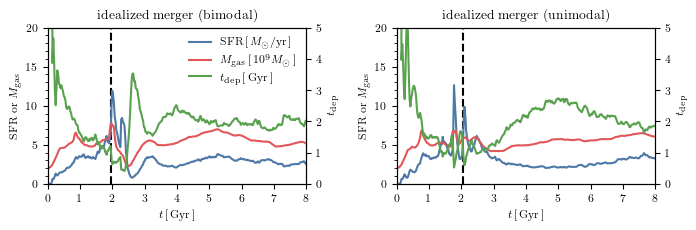

In [514]:
plt.close()
fig, axs = plt.subplots(1, 2, figsize=(textwidth, 0.7*columnwidth))

i_Fe = 9

for i,(ax,summary) in enumerate(zip(axs, [summary0, summary1])):
    l0 = ax.plot(summary['Time'], summary['globalSFR'], c=tb_c[0], 
             label=r'$\textrm{SFR}\,[\,M_{\odot}/\textrm{yr}\,]$')
    l1 = ax.plot(summary['Time'], 10*summary['globalMgas'], 
             c=tb_c[2], label=r'$M_{\textrm{gas}}\,[\,10^{9}M_{\odot}\,]$')
    ax2 = ax.twinx()
    l2 = ax2.plot(summary['Time'], 10*summary['globalMgas']/summary['globalSFR'], 
              c=tb_c[4], label=r'$t_{\textrm{dep}}\,[\,\textrm{Gyr}\,]$')
    
    if i==0:
        lns = l0 + l1 + l2
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, frameon=False)
    
    ax2.set(ylim=(0, 5))
    ax.set(xlim=(0, 8), ylim=(0, 20))
    
    ax.set(xlabel=r'$t\,[\,\textrm{Gyr}\,]$', 
       ylabel=r'$\textrm{SFR or }M_{\textrm{gas}}$')
    ax.set(xlabel=r'$t\,[\,\textrm{Gyr}\,]$')
    ax2.set(ylabel=r'$t_{\textrm{dep}}$')

    ax.set(xticks=np.arange(0, 8+1, 1))
    ax.set_yticks(np.arange(0, 20+1, 1), minor=True)

axs[0].axvline(mergesnap0 * 0.025, c='k', ls='dashed', zorder=-1)
axs[1].axvline(mergesnap1 * 0.025, c='k', ls='dashed', zorder=-1)

axs[0].set_title(r'$\textrm{idealized merger (bimodal)}$')
axs[1].set_title(r'$\textrm{idealized merger (unimodal)}$')

fig.tight_layout()
fig.savefig('SFR_Mgas_tdep.pdf')

# AGN

In [6]:
sim = ('129', '142', '04') # aa
key = 'lvl4-Rs'+sim[0]+'-Vv'+sim[1]+'-e'+sim[2]
output_dir = basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output'
idx = 120

t = h5.File(output_dir + '/snapshot_'+str(idx).zfill(3)+'.hdf5', mode='r')

print(t['Header'].attrs['NumPart_Total'][5])

print(t['PartType5/Masses'][0])

for k in t['PartType5'].keys():
    print(k)

t.close()

1
0.002884965
BH_CumEgyInjection_QM
BH_CumEgyInjection_RM
BH_CumMassGrowth_QM
BH_CumMassGrowth_RM
BH_Density
BH_HostHaloMass
BH_Hsml
BH_MPB_CumEgyHigh
BH_MPB_CumEgyLow
BH_Mass
BH_Mdot
BH_MdotBondi
BH_MdotEddington
BH_Pressure
BH_Progs
BH_U
Coordinates
Masses
ParticleIDs
Potential
Velocities


In [7]:
0.002486828 * 1e10/1e6

24.86828

In [15]:
summary0.keys()

dict_keys(['Time', 'Mstar', 'dMstar', 'globalMstar', 'Mgas', 'SFR', 'globalSFR', 'globalMgas', 'Mgas_inFeHbin', 'SFR_inFeHbin', 'medalpha_inFeHbin', 'MFe_inFeHbin_cen', 'MMg_inFeHbin_cen', 'MFe_inFeHbin_sat', 'MMg_inFeHbin_sat', 'Mgas_cen', 'Mgas_sat', 'dlogFeH'])

In [18]:
simi = ('129', '142', '04')
summary0 = get_dat_summary(simi, rmin=0, rmax=12)
orbit0 = get_orbit(*simi)

100%|██████████| 321/321 [00:00<00:00, 1128.47it/s]


/tmp/ipykernel_1272628/1302482448.py:7: RuntimeWarning: invalid value encountered in divide
  lns += ax.plot(summary['Time'], summary['BH_Mdot']/summary['BH_MdotEddington'],


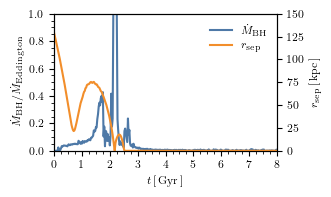

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(columnwidth, 0.6*columnwidth))

lns = []
summary = summary0
orbit = orbit0

lns += ax.plot(summary['Time'], summary['BH_Mdot']/summary['BH_MdotEddington'], 
               c=tb_c[0], label=r'$\dot{M}_{\textrm{BH}}$')
ax2 = ax.twinx()
lns += ax2.plot(orbit['Time'], orbit['Rsep'], c=tb_c[1], label=r'$r_{\textrm{sep}}$')
# ax.plot(summary1['Time'], 10*summary1['BH_Mdot'])

labs = [l.get_label() for l in lns]
ax.legend(lns, labs, frameon=False)

ax.set(ylim=(0, 1), xlim=(0, 8))
ax.set(xlabel=r'$t\,[\,\textrm{Gyr}\,]$',
       ylabel=r'$\dot{M}_{\textrm{BH}}/{\dot{M}_{\textrm{Eddington}}}$')

ax.set(xticks=np.arange(0, 8+1, 1))
ax.set_xticks(np.arange(0, 8+0.25, 0.25), minor=True)
ax.set_yticks(np.arange(0, 1+0.05, 0.05), minor=True)

ax2.set(ylim=(0, 150), ylabel=r'$r_{\textrm{sep}}\,[\,\textrm{kpc}\,]$')
fig.tight_layout()
fig.savefig('MdotBH_rsep.pdf')